# 011. PyTorch Dataset

### Dataset 클래스

 - PyTorch는 두 개의 데이터 관련 클라스를 제공하여 pre-loaded datasets 및 custom dataset 을 사용할 수 있도록 한다.
 
     - torch.utils.data.Dataset - 샘플 및 해당 레이블을 제공
     - torch.utils.data.DataLoader - 샘플에 쉽게 액세스 할 수 있도록 Dataset에 iterable 을 wrapping
     

- PyTorch domain library (Image, Text, Audio dataset) 들은 torch.utils.data.Dataset 을 상속 받은 pre-loaded dataset (ex. FashionMNIST)과 관련 함수 제공
 

- torch.utils.data.Dataset 은 데이터셋을 나타내는 추상클래스이다.


- custom 데이터셋은 Dataset 을 상속하고 아래와 같이 Dataset method 를 오버라이드 하여 작성


    - 생성자 __init__ 은 dataset 의 전처리를 해주는 부분
    - len(dataset) 에서 호출되는 __len__ 은 데이터셋의 크기를 리턴
    - dataset[i] 에서 호출되는 __getitem__ 은 𝑖 번째 샘플을 찾는데 사용

In [1]:
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.rcParams['figure.figsize'] = [3, 3]

<h1>pre-built Datasets and Transforms</h1> 

In [2]:
crop_tensor_transform = transforms.Compose(
                    [transforms.CenterCrop(20), 
                     transforms.ToTensor()])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=crop_tensor_transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=crop_tensor_transform
)

In [3]:
training_data[0][0].shape

torch.Size([1, 20, 20])

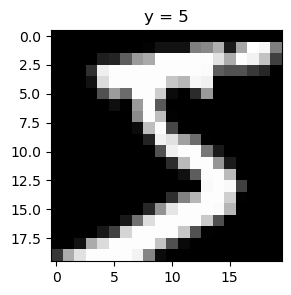

In [4]:
plt.imshow(training_data[0][0].view(20, 20), cmap="gray")
plt.title("y = {}".format(training_data[0][1]))
plt.show()

## DataLoader를 사용하여 training 데이터 준비

Dataset은 `한 번에 한 개씩 샘플`의 feature 와 label 을 retreive 합니다. 모델을 훈련하는 동안 일반적으로 `minibatch`로 샘플을 전달하고, 매 epoch 마다 데이터를 reshuffle 하여 overfitting을 줄이며, Python의 multiprocessing을 사용하여 읽는 속도를 높입니다.

DataLoader는 쉬운 API로 이러한 복잡성 내용을 추상화한 반복자(iterable) 입니다.

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

## DataLoader를 통해 반복
해당 데이터 세트를 ``Dataloader``에 로드 했으며 반복할 수 있습니다. 아래의 각 반복은`` train_features`` 및 ``train_labels`` ( batch_size=64 의 feature 및 label) 의 배치를 반환합니다.  ``shuffle=True``를 지정했기 때문에 모든 배치를 반복한 후에 데이터가 섞입니다.

In [6]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 20, 20])
Labels batch shape: torch.Size([64])


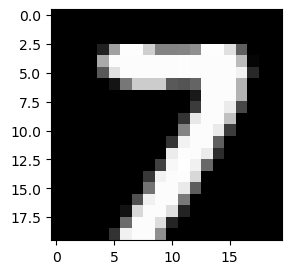

Label: 7


In [7]:
# Display image and label.
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 사용자 정의 Dataset 작성

- 특정 길이의 data를 생성하는 사용자 정의 Dataset class  
- transform object를 전달 받으면 data 변환을 하여 반환  
- iterable형태로 사용

In [8]:
class toy_set(Dataset):
    def __init__(self, data, label, transform=None):
        # dataset 을 전처리
        self.x = data
        self.y = label
        self.transform = transform
        
    def __getitem__(self, idx):
        # idx 번째 sample 1 개를 가져오는 함수
        sample = self.x[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
            
    def __len__(self):
        # dataset의 길이를 반환
        return len(self.x)

In [9]:
torch.manual_seed(10)

X = 10 * torch.ones(10, 2)
y = torch.ones(10, 1)

print(X, y)

tensor([[10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.],
        [10., 10.]]) tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


### Transform 적용

- 사용자 정의 transform module 을 Custom Dataset 에 적용

In [10]:
def scaling(sample):
    x, y = sample
    scaled_x = x / 10.
    scaled_y = y / 10.
    return scaled_x, scaled_y

test_data = toy_set(X, y, transform=scaling)

`__getitem__` 호출

In [11]:
for i in range(3):
    x, y = test_data[i]
    print(x, y)

tensor([1., 1.]) tensor([0.1000])
tensor([1., 1.]) tensor([0.1000])
tensor([1., 1.]) tensor([0.1000])


`__len__` 호출

In [12]:
len(test_data)

10

### iterable 형태로 사용

In [13]:
for x, y in test_data:
    print(x, y)
    break

tensor([1., 1.]) tensor([0.1000])


In [14]:
next(iter(test_data))

(tensor([1., 1.]), tensor([0.1000]))

In [15]:
test_data[-1]

(tensor([1., 1.]), tensor([0.1000]))

### transform class 적용 예

In [16]:
class add_ones:
    def __call__(self, sample):
        x, y = sample
        x = x + 1
        y = y + 1
        sample = x, y
        return sample

In [17]:
a_m = add_ones()

dataset_ = toy_set(X, y, transform=a_m)
dataset_[-1]

(tensor([11., 11.]), tensor(1.1000))

### Transform 을 동시에 여러개 적용 : transform.Compose 

In [18]:
from torchvision import transforms

data_transforms = transforms.Compose([scaling, a_m])

In [19]:
data1 = toy_set(X, y, transform=data_transforms)
next(iter(data1))

(tensor([2., 2.]), tensor(1.0100))

## TensorDataset
- PyTorch의 TensorDataset은 tensor를 감싸는 Dataset입니다.
- TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓는 컨테이너입니다.
- TensorDataset을 DataLoader에 전달하면 for 루프에서 데이터의 일부분만 간단히 추출할 수 있게 됩니다.  
- TensorDataset에는 텐서만 전달할 수 있으며, Variable은 전달할 수 없으니 주의
- Dataset은 직접 작성할 수도 있어서 대량의 이미지 파일을 한 번에 메모리에 저장하지 않고 필요할 때마다 읽어서 학습하는 등 다양하게 활용 가능

In [20]:
from torch.utils.data import TensorDataset
import numpy as np

In [21]:
x = np.random.randn(5, 4)
y = np.random.randint(0, 2, size=5)

X_train = torch.from_numpy(x)
y_train = torch.from_numpy(y)

print(X_train)
print(y_train)

tensor([[ 0.6825,  0.9433,  0.2923,  1.8825],
        [-0.9087,  0.1513, -0.5345,  1.3351],
        [-0.3907, -0.0637,  1.9549, -0.8753],
        [-1.0001, -0.9947, -1.7194, -2.3959],
        [ 1.2072,  1.0029, -0.3141, -0.3566]], dtype=torch.float64)
tensor([1, 1, 1, 1, 1], dtype=torch.int32)


In [22]:
train_ds = TensorDataset(X_train, y_train)
train_ds

In [23]:
train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=False)
train_dataloader

In [24]:
train_features, train_labels = next(iter(train_dataloader))
train_features, train_labels

(tensor([[ 0.6825,  0.9433,  0.2923,  1.8825],
         [-0.9087,  0.1513, -0.5345,  1.3351]], dtype=torch.float64),
 tensor([1, 1], dtype=torch.int32))